# Sequana_coverage versus CNVnator (viral genome)

This notebook compares CNVnator, CNOGpro and sequana_coverage behaviour on a viral genome instance (same as in the virus notebook).


Versions used:
- sequana 0.7.0

In [17]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [10,7]

Populating the interactive namespace from numpy and matplotlib


Here below, we provide the results of the sequana_coverage and CNVNator analysis as files within this directory itself. Nevertheless, if you need to rerun the analysis yourself, you can still do it but you need to generate the BAM file for CNVnator (see virus notebook). For sequana_coverage, you could use the BED file directly, which is also used here below for the plotting. This BED file can simply be downloaded as follows.

In [2]:
!wget https://github.com/sequana/resources/raw/master/coverage/JB409847.bed.bz2
!bunzip2 JB409847.bed.bz2

--2018-07-23 22:54:23--  https://github.com/sequana/resources/raw/master/coverage/JB409847.bed.bz2
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sequana/resources/master/coverage/JB409847.bed.bz2 [following]
--2018-07-23 22:54:24--  https://raw.githubusercontent.com/sequana/resources/master/coverage/JB409847.bed.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.120.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.120.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63485 (62K) [application/octet-stream]
Saving to: ‘JB409847.bed.bz2’

JB409847.bed.bz2    100%[===================>]  62.00K  --.-KB/s    in 0.02s   

2018-07-23 22:54:24 (3.91 MB/s) - ‘JB409847.bed.bz2’ saved [63485/63485]



# The coverage signal

Let us have a quick look at the coverage itself.

In [14]:
from sequana import GenomeCov
b = GenomeCov("JB409847.bed")
chromosome = b.chr_list[0]
chromosome.run(4001, 2, circular=True)

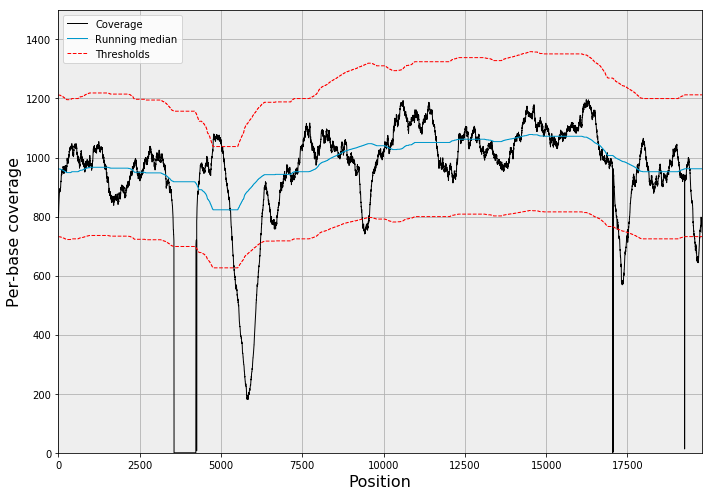

In [18]:
chromosome.plot_coverage()
_ = ylim([0,1500])

What you see are two long deleted regions of about 700 bases (one fully deleted) and two 3-bases deleted regions on the right hand side. Our goal is to detect those 4 events automatically.

# Get ROIs using sequana_coverage

We ran the analysis with circular chromosome set on and a window parameter of
- 1000
- 2000
- 3000
- 4000

For example:
```
sequana_coverage -o -input JB409847.bed --no-html --no-multiqc -w 3000
```

Results are available in 4 files for your convenience: e.g. rois_1000.csv, rois_4000.csv

Note that the window size cannot be larger than a fifth of the genome length from the command line. Would you need to force it, you would need to use the library itself.

# Get ROIs using CNVnator

```
cnvnator -root out1.root -tree JB409847.bed 
cnvnator -root out1.root -his 1
cnvnator -root out1.root -stat 1
cnvnator -root out1.root -partition 1 -ngc
cnvnator -root out1.root -call 1 -ngc > events_bin1.txt
```

The default parameter of 100 gives no detection. We then used bin=1, 5, 10, 20 and stored the results in:

- events_bin1.txt
- events_bin5.txt
- events_bin10.txt
- events_bin20.txt

# How  events are detected using CNVnator?

In [8]:
from sequana.cnv import CNVnator

In [9]:
cnv1 = CNVnator("events_bin1.txt").df
cnv5 = CNVnator("events_bin5.txt").df
cnv10 = CNVnator("events_bin10.txt").df
cnv20 = CNVnator("events_bin20.txt").df

In [10]:
def plot_rois_cnv(cnv):
    chromosome.plot_coverage()
    for _, this in cnv.iterrows():
        type_ = this['type']
        positions = [this.start, this.end]
        if type_ == "deletion":
            fill_between(positions, 0, 1000)
        else:
            fill_between(positions, 1000,2000)
    ylim([0,2000])    

## binning of 20 and 10

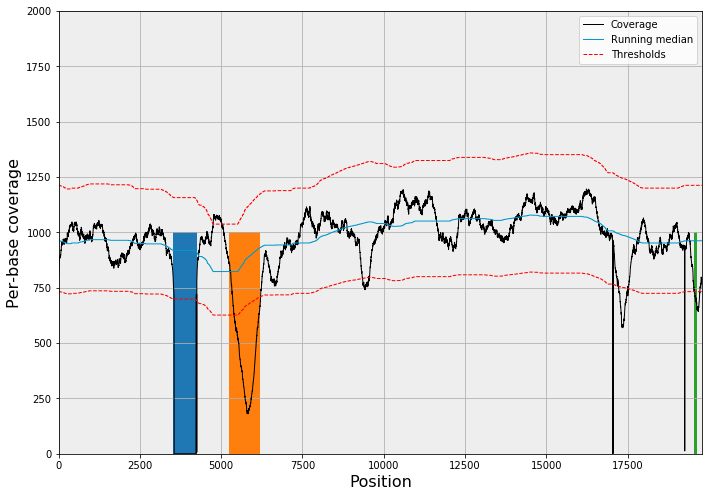

In [11]:
plot_rois_cnv(cnv10)

Here, the two main events on the left hand side (deleted regions of several hundreds of bases) are detected. However, the short deleted regions on the right hand side (a few bases) are not. 



# Binning of 5

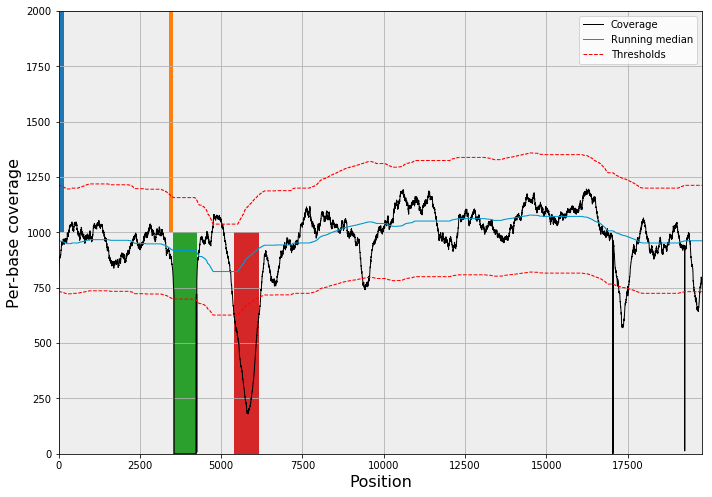

In [12]:
plot_rois_cnv(cnv5)

Here again, the two main deleted regions are detected but the two short events
are not. There is also a false detection at position 0 and around 4000

# Binning of 1

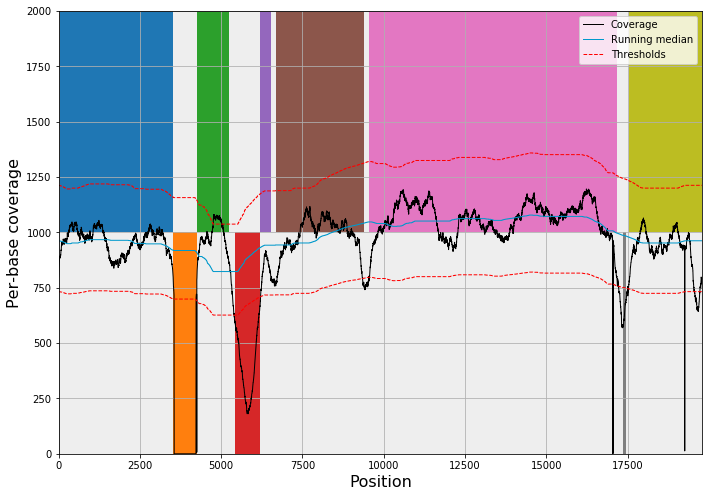

In [13]:
plot_rois_cnv(cnv1)

binning of 1 is too small: the low deleted regions are detected but then, the small 
    deleted regions are not and there are lots of upper regions classified as duplicated CNVs.

# How  events are detected using sequana_coverage ?

In [28]:
# W can be 1000,2000,3000,4000
import pandas as pd
def plot_rois_sequana(W):
    assert W in [2000, 3000, 4000, 1000,5000, "4000_t3"]
    if W == "4000_t3":
        chromosome.run(4001, circular=True)
    else:
        chromosome.run(W+1, circular=True)
    chromosome.plot_coverage(sample=False)
    rois = pd.read_csv("rois_{}.csv".format(W))
    for _, this in rois.iterrows():
        #if this.max_zscore >-4.5 and this.max_zscore<4.5 and this.max_cov!=0:
        #    continue    
        positions = [this.start, this.end]
            
        if abs(this.mean_zscore) >12: col="red"
        elif abs(this.mean_zscore) >8: col="orange"
        elif abs(this.mean_zscore) >4: col="yellow"
            
        if this.mean_zscore > 0:
            fill_between(positions, 1000, 2000, color=col)        
        else:
            fill_between(positions, 0, 1000, color=col)
        if this.end-this.start < 100:
            axvline(this.start, ymax=0.5, lw=3, color="r")
    ylim([0,2000])

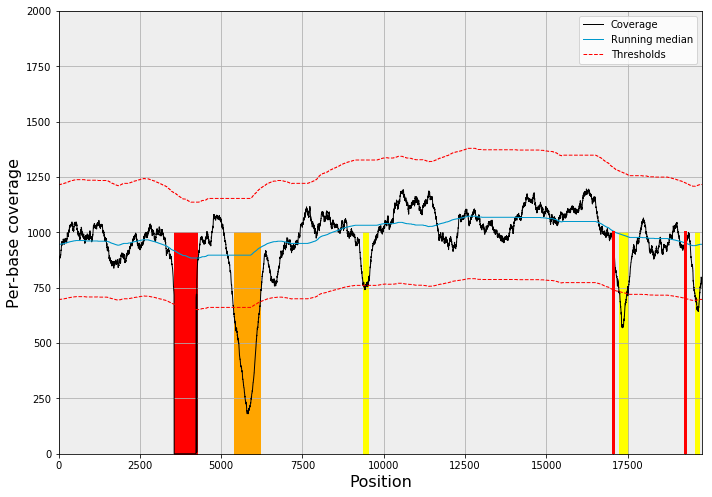

In [29]:
plot_rois_sequana(5000)

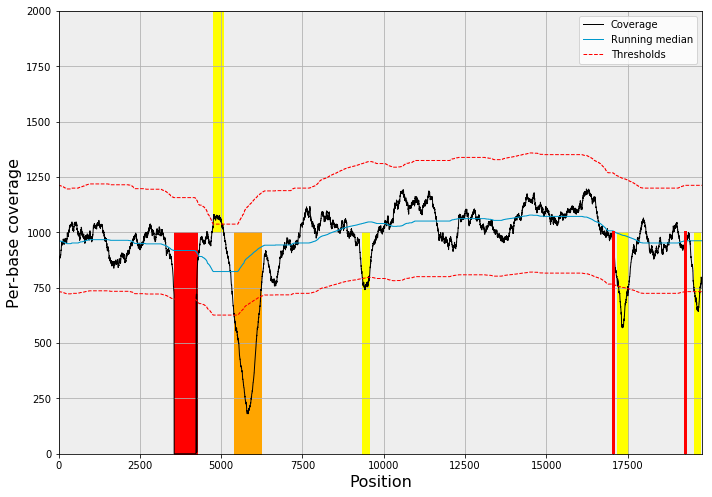

In [71]:
plot_rois_sequana(4000)

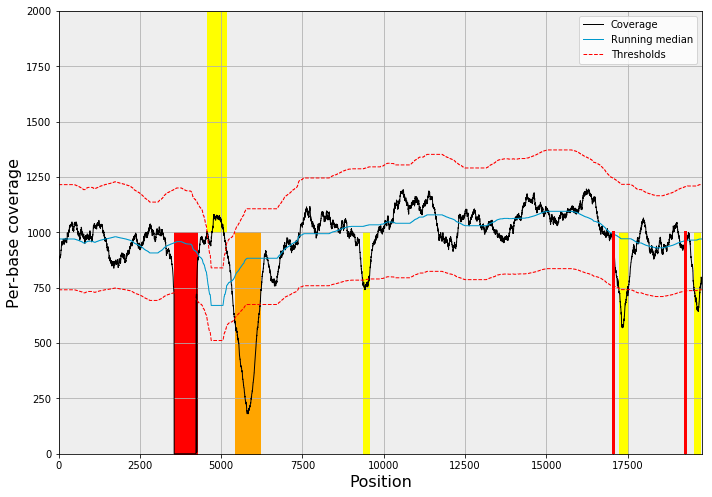

In [40]:
plot_rois_sequana(3000)

Using W=2000, 3000, 4000 the results are robust and consistent: the same ROIs are detected. In particular, the 2 long and 2 short deleted regions are detected; 
    
In addition, some short events not fully deleted are also systematically detected. The detection seems coherent visually except maybe for the duplicated events at position 5000, which could be considered a false detection. Note, however, that the zscore associated with this events could be used to discard the events (mean zscore of 5)

In [26]:
rois = pd.read_csv("rois_4000.csv")
rois[["start", "end", "size", "mean_rm", "max_zscore", "log2_ratio"]]

,start,end,size,mean_rm,max_zscore,log2_ratio
0,3553,4252,699,919.410587,-16.204462,-5.224348
1,4756,5051,295,821.044068,4.864558,0.369192
2,5399,6212,813,877.333333,-12.933157,-1.128289
3,9344,9561,217,1043.811060,-4.815085,-0.445117
4,17045,17048,3,1005.000000,-16.204462,-9.972980
5,17052,17053,1,1005.000000,-16.140656,-7.972980
6,17186,17525,339,987.203540,-6.962564,-0.544632
7,19257,19258,1,962.000000,-15.987824,-6.209453
8,19554,19722,168,963.000000,-5.483700,-0.492862


Now, if we decrease the W parameter to 1000, we may miss the large deleted regions, 
which length is 711 and 782 (to detect those events we recommend to use W as
twice this length so about 1500)

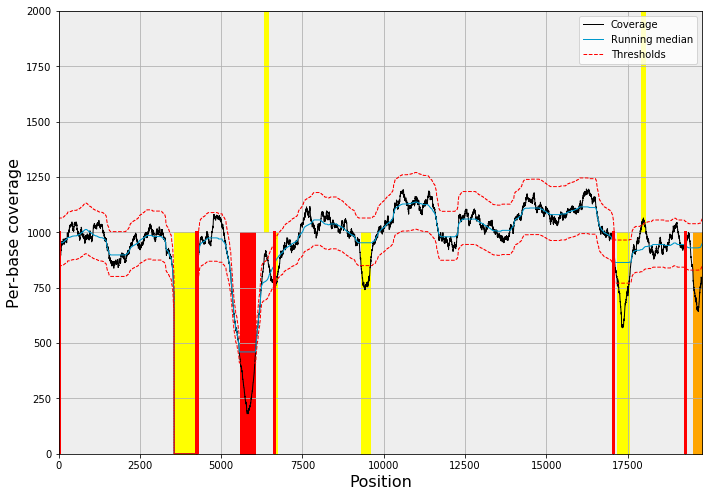

In [82]:
plot_rois_sequana(1000)

So, here we still detect the two deleted regions but we see that the running 
median fits the data too closely. Consequently, we have some 
false detections at position 0, 6600, 17923 to cite a few examples. 

# CNOGpro detection

Running CNOGpro manually using window length of 100 and 10, we get these 
results

In [58]:
CNOGpro_10 = [[3521, 4220, 0], [4221, 4230, 5], 
               [4241,4250,0], [4251,4260,3],
              [5681,5740,0], [19771,19795,0]]
CNOGpro_100 = [[3601,4200,0], [4201,4300,3], [4301,4400,2]]

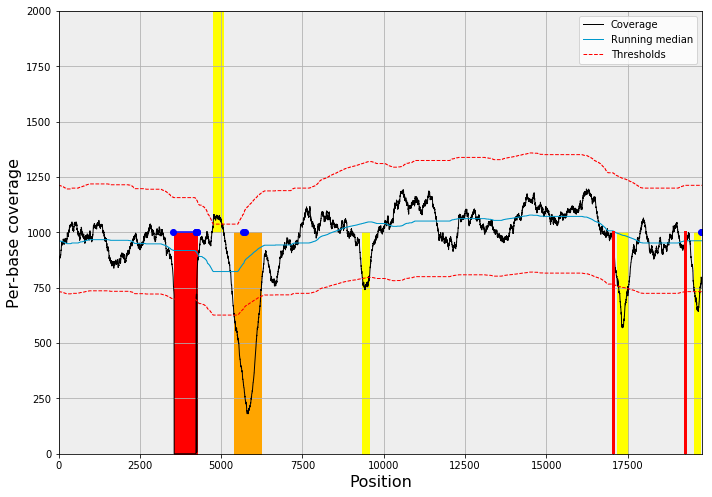

In [75]:
plot_rois_sequana(4000)
for this in CNOGpro_10:
    plot(this[0:2], [1000, 1000], "ob-")

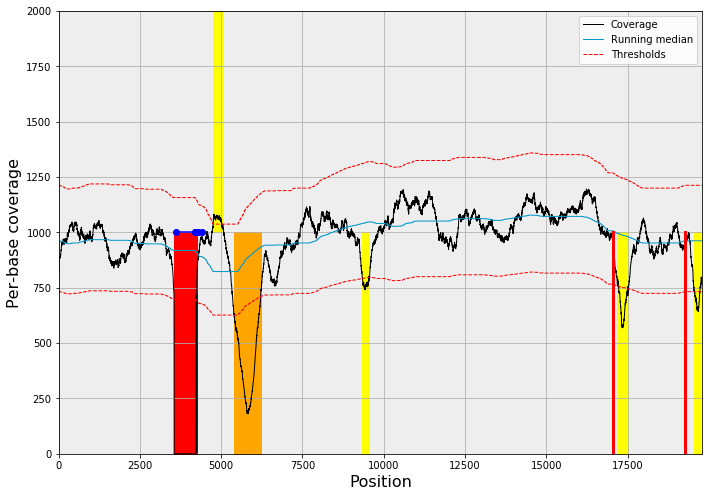

In [76]:
plot_rois_sequana(4000)
for this in CNOGpro_100:
    axhline(1000, this[0], 1000, color="r", lw=20)
    plot(this[0:2], [1000, 1000], "ob-")

# Conclusions

On a viral genome (length 18000), we use sequana_coverage and cnvnator to detect events of interests that can be seen by eyes on the coverage signals that is one deleted region of about 700 bases, one depleted region of about 700 and two short deleted regions of a few bases long.

Sequana_coverage detects those 4 events with the default parameter (window length set to a fifth of the full genome length). It is also robust with respect to the parameter (2000, 3000, 4000 that give the same results). Note, however, that a window of 1000 is too short and lead to possibly false detections. Those false detections could be easily removed using the mean zscore associated with these events.

CNVnator detects the two long deleted events. However, the two short deleted ones are systematically missed, which is not surprising since CNVnator is designed to detect long regions. Depending of the bin parameter, there are a few false detections. Decreasing to a bin of 1, the results are difficult to assess since most of the genome is classified as a mix of regions of interests.

CNOGpro detects the two long deleted events. However, their exact duration is not correct. Short events are missed using bins of 5, 10, 100, 200.

**computation time:**

- sequana_coverage: (with --no-html and --no-multiqc options), sequana_coverage takes 2.5 seconds irrespective of the window parameter
- cnvnator: 8.5 s for bin=5 or 10, 18s for bins=1